In [1]:
# Install all packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
!pip install missingno
import missingno as msno
!pip install -U miceforest plotnine
import miceforest as mf
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

##  Missing Data Investigation

Investigate the missing data in this dataset. Specifically, for each of the following variables that have missing data, decide if any imputation is possible. Give your reasoning and code if you decide to impute missing values.

###  Columns for Investigation:
- `CARRIER`
- `CARRIER_NAME`
- `MANUFACTURE_YEAR`
- `NUMBER_OF_SEATS`
- `CAPACITY_IN_POUNDS`
- `AIRLINE_ID`

*Hint:* Watch out for `"North American Airlines"` aircrafts — are the `CARRIER` / `UNIQUE_CARRIER` columns really missing?


In [2]:
pd.set_option('display.precision', 3)

aircraft = pd.read_csv('T_F41SCHEDULE_B43.zip')
aircraft.head()

<ipython-input-2-55a0275c1e77>:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  aircraft = pd.read_csv('T_F41SCHEDULE_B43.zip')


,YEAR,CARRIER,CARRIER_NAME,MANUFACTURE_YEAR,UNIQUE_CARRIER_NAME,SERIAL_NUMBER,TAIL_NUMBER,AIRCRAFT_STATUS,OPERATING_STATUS,NUMBER_OF_SEATS,MANUFACTURER,AIRCRAFT_TYPE,MODEL,CAPACITY_IN_POUNDS,ACQUISITION_DATE,AIRLINE_ID,UNIQUE_CARRIER
0,2006,16,PSA Airlines Inc.,2003.0,PSA Airlines Inc.,7858,N202PS,B,Y,50.0,CANADAIR,NaN,CRJ-2/4,47000.0,10/28/2003 12:00:00 AM,20397.0,16
1,2006,16,PSA Airlines Inc.,2003.0,PSA Airlines Inc.,7860,N206PS,B,Y,50.0,CANADAIR,NaN,CRJ-2/4,47000.0,10/30/2003 12:00:00 AM,20397.0,16
2,2006,16,PSA Airlines Inc.,2003.0,PSA Airlines Inc.,7873,N207PS,B,Y,50.0,CANADAIR,NaN,CRJ-2/4,47000.0,11/26/2003 12:00:00 AM,20397.0,16
3,2006,16,PSA Airlines Inc.,2003.0,PSA Airlines Inc.,7874,N209PS,B,Y,50.0,CANADAIR,NaN,CRJ-2/4,47000.0,12/4/2003 12:00:00 AM,20397.0,16
4,2006,16,PSA Airlines Inc.,2003.0,PSA Airlines Inc.,7879,N213PS,B,Y,50.0,CANADAIR,NaN,CRJ-2/4,47000.0,12/16/2003 12:00:00 AM,20397.0,16


In [3]:
aircraft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132313 entries, 0 to 132312
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 132313 non-null  int64  
 1   CARRIER              132264 non-null  object 
 2   CARRIER_NAME         132208 non-null  object 
 3   MANUFACTURE_YEAR     132310 non-null  float64
 4   UNIQUE_CARRIER_NAME  132208 non-null  object 
 5   SERIAL_NUMBER        132313 non-null  object 
 6   TAIL_NUMBER          132313 non-null  object 
 7   AIRCRAFT_STATUS      132313 non-null  object 
 8   OPERATING_STATUS     132313 non-null  object 
 9   NUMBER_OF_SEATS      132306 non-null  float64
 10  MANUFACTURER         132313 non-null  object 
 11  AIRCRAFT_TYPE        102380 non-null  object 
 12  MODEL                132302 non-null  object 
 13  CAPACITY_IN_POUNDS   132212 non-null  float64
 14  ACQUISITION_DATE     131346 non-null  object 
 15  AIRLINE_ID       

<Axes: >

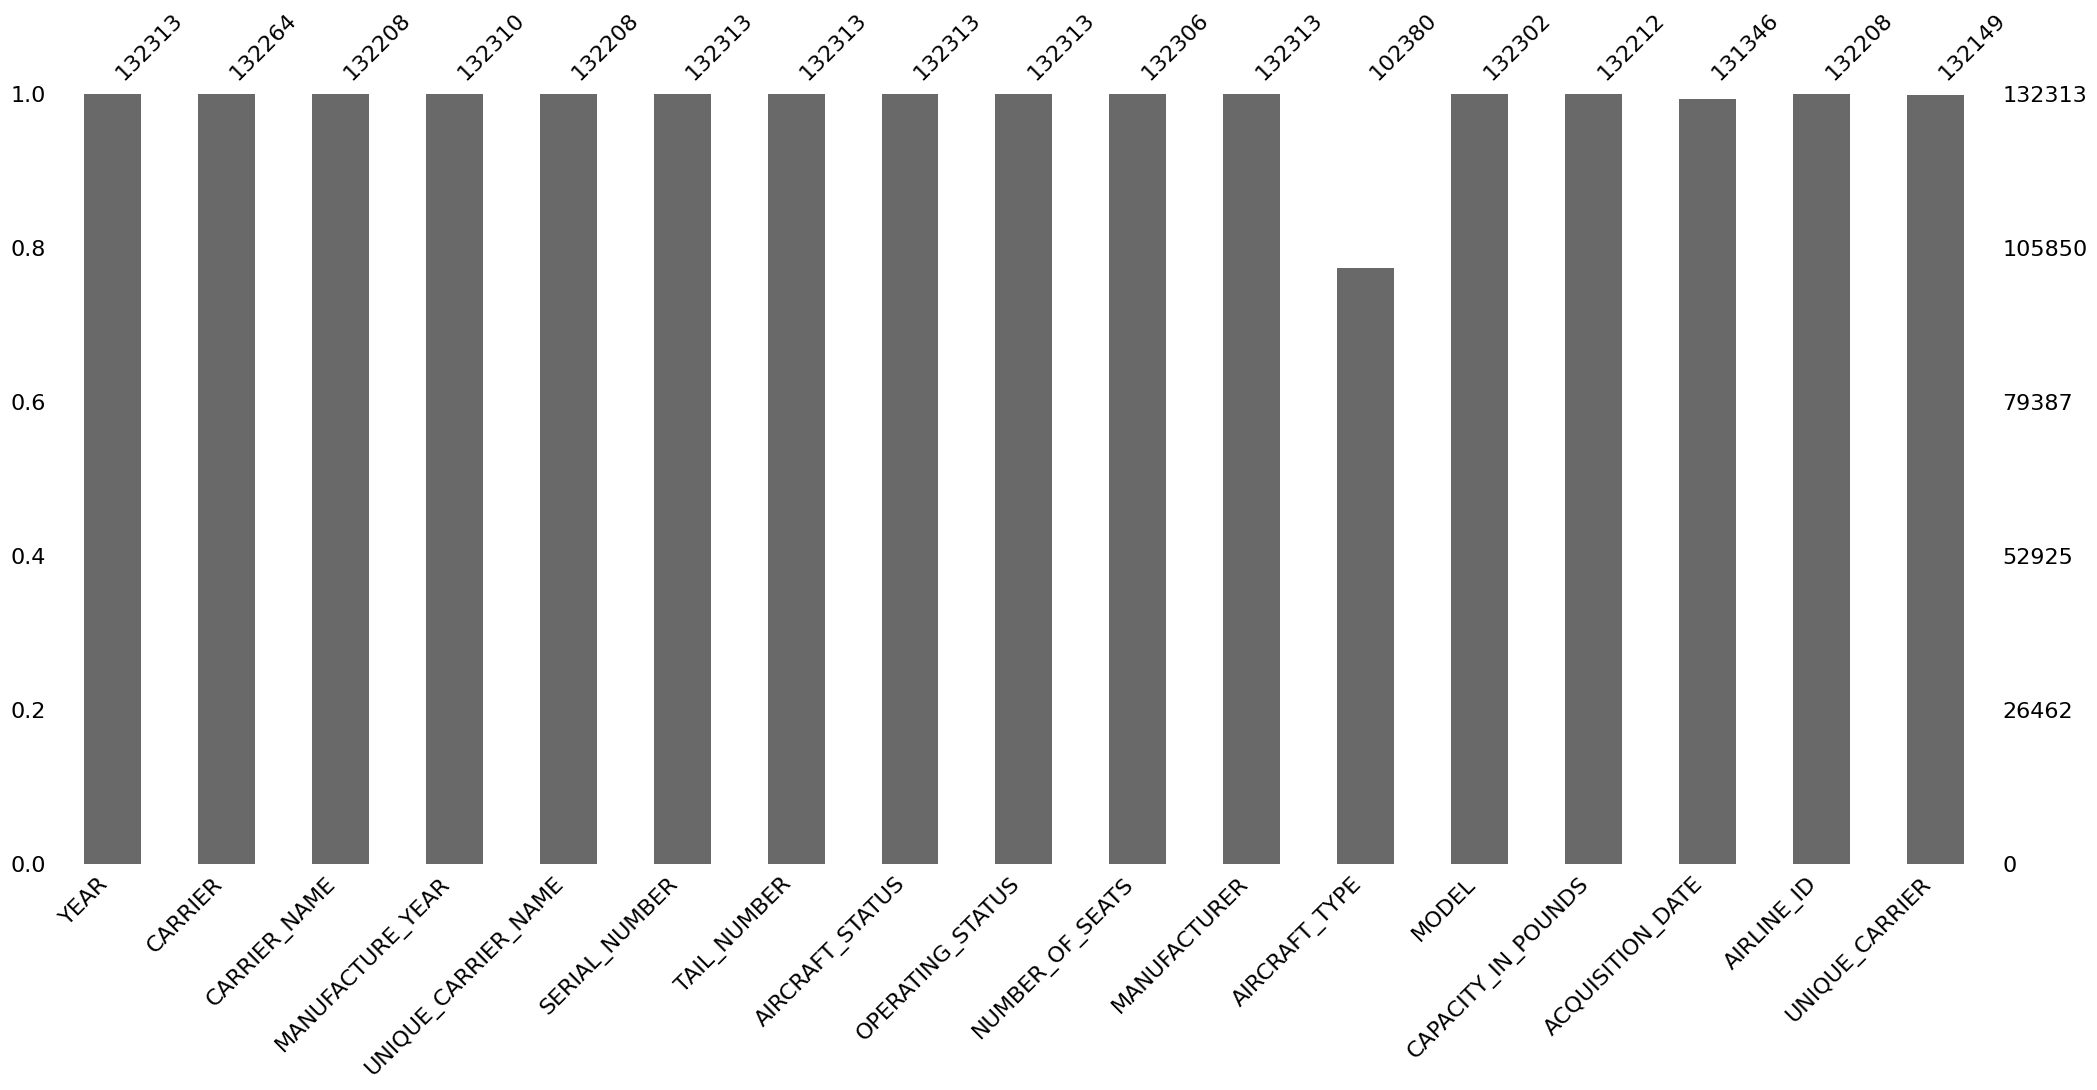

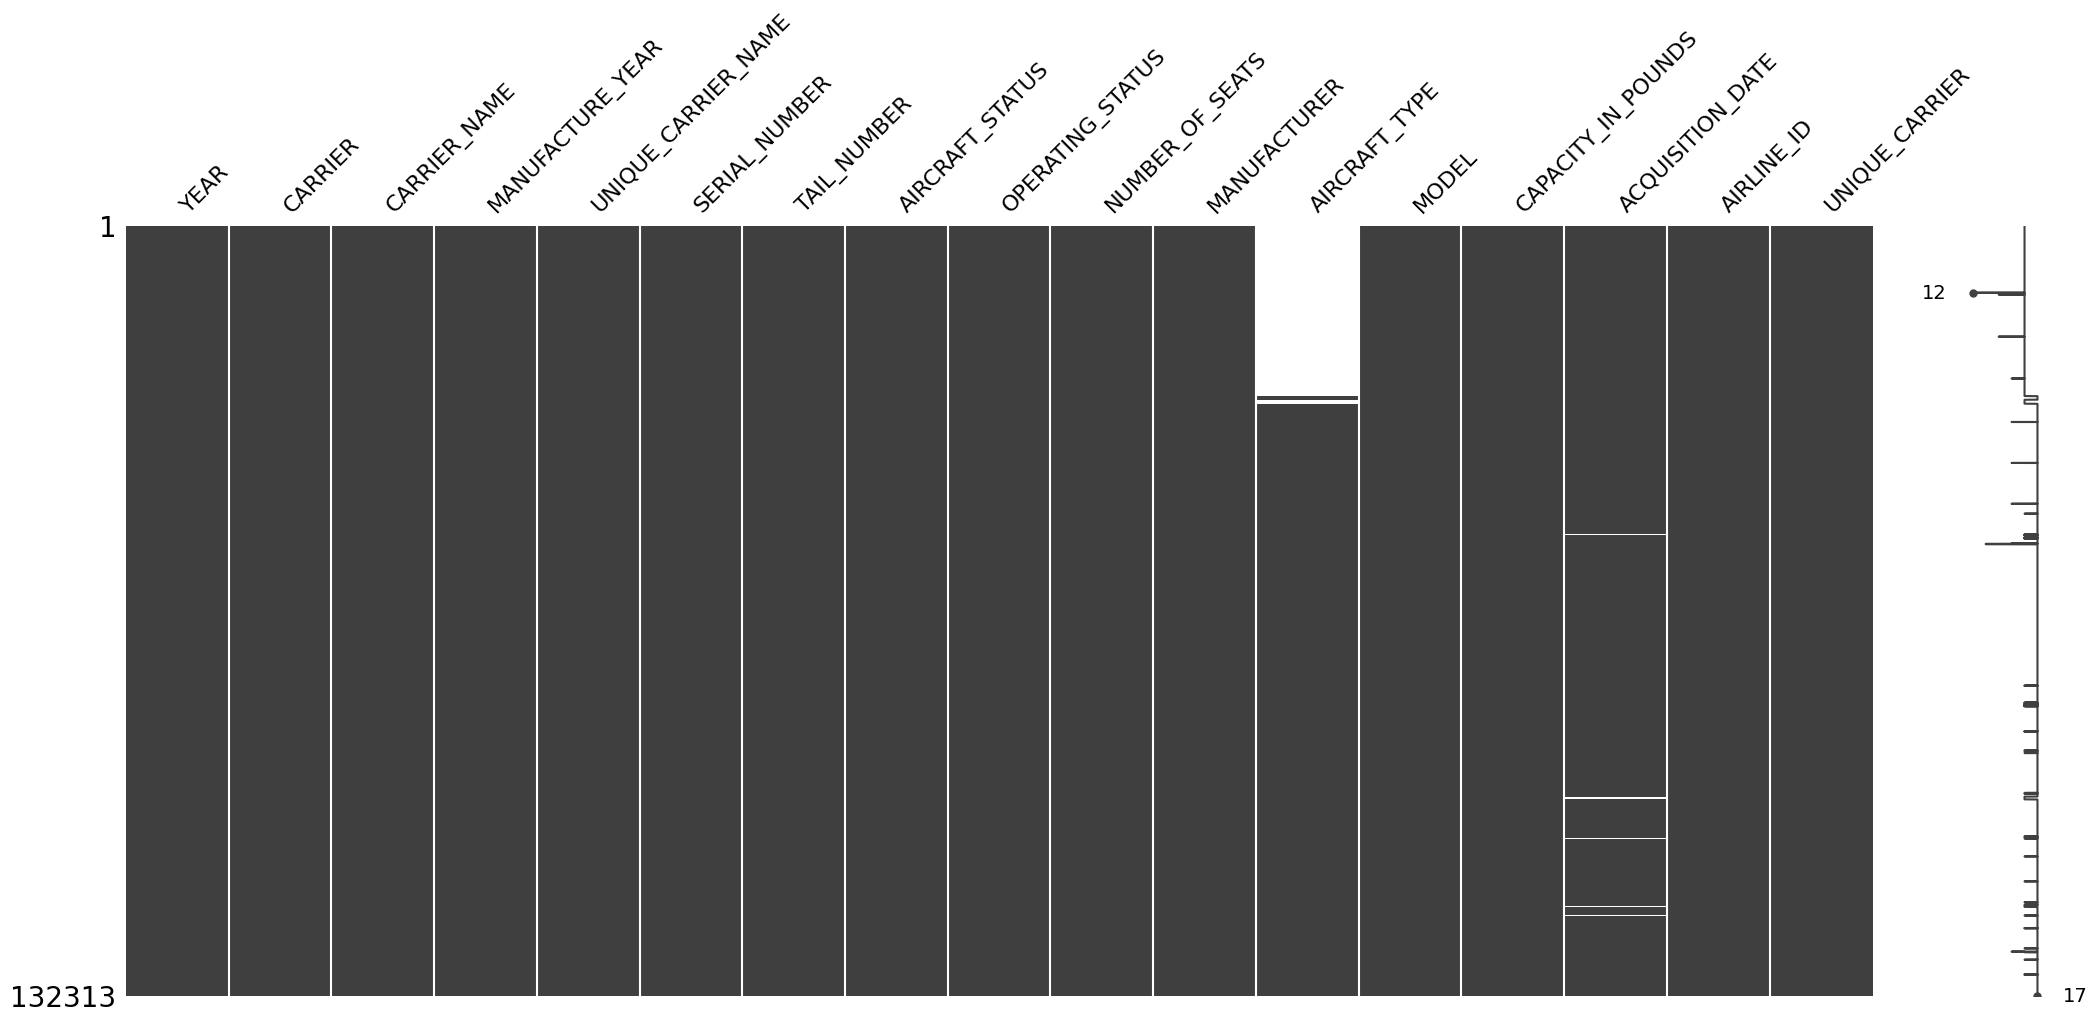

In [4]:
msno.bar(aircraft)
msno.matrix(aircraft)

# Carrier Imputation
We are able to impute on this as we're able to see that carrier and carrier name should match but we should be sure of this by checking for mapping of carriers to any other variable to see if there is anything unique when comparing the two. If we are able to find unique mappings, we can impute based on this, but if not, imputation is not possible.



In [5]:
one_to_one_names = (
    aircraft[['CARRIER_NAME', 'CARRIER']]
    .dropna()
    .drop_duplicates()
    .groupby('CARRIER_NAME')['CARRIER']
    .nunique()
    .loc[lambda x: x == 1]
    .index
)

carrier_map = (
    aircraft[aircraft['CARRIER_NAME'].isin(one_to_one_names)][['CARRIER_NAME', 'CARRIER']]
    .dropna()
    .drop_duplicates()
    .set_index('CARRIER_NAME')['CARRIER']
    .to_dict()
)

aircraft_imputer = aircraft.copy()
mask = aircraft_imputer['CARRIER'].isnull() & aircraft_imputer['CARRIER_NAME'].isin(carrier_map)
aircraft_imputer.loc[mask, 'CARRIER'] = aircraft_imputer.loc[mask, 'CARRIER_NAME'].map(carrier_map)

aircraft_imputer.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132313 entries, 0 to 132312
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 132313 non-null  int64  
 1   CARRIER              132313 non-null  object 
 2   CARRIER_NAME         132208 non-null  object 
 3   MANUFACTURE_YEAR     132310 non-null  float64
 4   UNIQUE_CARRIER_NAME  132208 non-null  object 
 5   SERIAL_NUMBER        132313 non-null  object 
 6   TAIL_NUMBER          132313 non-null  object 
 7   AIRCRAFT_STATUS      132313 non-null  object 
 8   OPERATING_STATUS     132313 non-null  object 
 9   NUMBER_OF_SEATS      132306 non-null  float64
 10  MANUFACTURER         132313 non-null  object 
 11  AIRCRAFT_TYPE        102380 non-null  object 
 12  MODEL                132302 non-null  object 
 13  CAPACITY_IN_POUNDS   132212 non-null  float64
 14  ACQUISITION_DATE     131346 non-null  object 
 15  AIRLINE_ID       

# Carrier Name Imputation
We should be able to impute unique values using our imputed dataset from above that was imputed using objective values and should be accurate in its missing information.

In [6]:
one_to_one_carriers = (
    aircraft_imputer[['CARRIER', 'CARRIER_NAME']]
    .dropna()
    .drop_duplicates()
    .groupby('CARRIER')['CARRIER_NAME']
    .nunique()
    .loc[lambda x: x == 1]
    .index
)

carriername_map = (
    aircraft_imputer[aircraft_imputer['CARRIER'].isin(one_to_one_carriers)][['CARRIER', 'CARRIER_NAME']]
    .dropna()
    .drop_duplicates()
    .set_index('CARRIER')['CARRIER_NAME']
    .to_dict()
)

mask = aircraft_imputer['CARRIER_NAME'].isnull() & aircraft_imputer['CARRIER'].isin(carriername_map)
aircraft_imputer.loc[mask, 'CARRIER_NAME'] = aircraft_imputer.loc[mask, 'CARRIER'].map(carriername_map)

aircraft_imputer.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132313 entries, 0 to 132312
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 132313 non-null  int64  
 1   CARRIER              132313 non-null  object 
 2   CARRIER_NAME         132216 non-null  object 
 3   MANUFACTURE_YEAR     132310 non-null  float64
 4   UNIQUE_CARRIER_NAME  132208 non-null  object 
 5   SERIAL_NUMBER        132313 non-null  object 
 6   TAIL_NUMBER          132313 non-null  object 
 7   AIRCRAFT_STATUS      132313 non-null  object 
 8   OPERATING_STATUS     132313 non-null  object 
 9   NUMBER_OF_SEATS      132306 non-null  float64
 10  MANUFACTURER         132313 non-null  object 
 11  AIRCRAFT_TYPE        102380 non-null  object 
 12  MODEL                132302 non-null  object 
 13  CAPACITY_IN_POUNDS   132212 non-null  float64
 14  ACQUISITION_DATE     131346 non-null  object 
 15  AIRLINE_ID       

# Manufacture Year
I would like to impute by first calculating age which will be done by first observing a model and then taking the difference between each of the manufacture years within that model and the year recorded to get an approximate age for the aircraft. Using this, I would like to take the median or mean age and for each year, calculate the manufacture year based on recorded year and model.

In [7]:
aircraft_imputer['AGE'] = aircraft_imputer['YEAR'] - aircraft_imputer['MANUFACTURE_YEAR']

median_age_by_model = (
    aircraft_imputer[['MODEL', 'AGE']]
    .dropna()
    .groupby('MODEL')['AGE']
    .median()
    .to_dict()
)

mask = aircraft_imputer['MANUFACTURE_YEAR'].isnull() & aircraft_imputer['MODEL'].isin(median_age_by_model)

aircraft_imputer.loc[mask, 'MANUFACTURE_YEAR'] = aircraft_imputer.loc[mask].apply(
    lambda row: row['YEAR'] - median_age_by_model[row['MODEL']], axis=1
)

aircraft_imputer.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132313 entries, 0 to 132312
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 132313 non-null  int64  
 1   CARRIER              132313 non-null  object 
 2   CARRIER_NAME         132216 non-null  object 
 3   MANUFACTURE_YEAR     132313 non-null  float64
 4   UNIQUE_CARRIER_NAME  132208 non-null  object 
 5   SERIAL_NUMBER        132313 non-null  object 
 6   TAIL_NUMBER          132313 non-null  object 
 7   AIRCRAFT_STATUS      132313 non-null  object 
 8   OPERATING_STATUS     132313 non-null  object 
 9   NUMBER_OF_SEATS      132306 non-null  float64
 10  MANUFACTURER         132313 non-null  object 
 11  AIRCRAFT_TYPE        102380 non-null  object 
 12  MODEL                132302 non-null  object 
 13  CAPACITY_IN_POUNDS   132212 non-null  float64
 14  ACQUISITION_DATE     131346 non-null  object 
 15  AIRLINE_ID       

# Number of Seats
We can impute number of seats likely by using the model that is in the dataset to extract the number given as models of aircraft are supposed to be specified and unique in their specs. Though in this case, missing data is characterized by a missing model as well so these rows should be dropped instead of imputed.

# Capacity in Pounds
This can be done by first checking if manufactures produce only one model in this dataset and if not it should be imputed by the plane model which will be shown below. It appears in analysis that imputation by model will not work as there are slight differences in capacity for some values, so the median can be used based on model with drops happening after imputing.

In [8]:
# Count how many unique models each manufacturer makes
model_count_by_manufacturer = (
    aircraft_imputer[['MANUFACTURER', 'MODEL']]
    .dropna()
    .drop_duplicates()
    .groupby('MANUFACTURER')['MODEL']
    .nunique()
    .reset_index(name='NUM_MODELS')
    .sort_values(by='NUM_MODELS', ascending=False)
)

# Display the table
model_count_by_manufacturer

# Filter for rows where both CAPACITY_IN_POUNDS and MODEL are missing
missing_both = aircraft_imputer[
    aircraft_imputer['CAPACITY_IN_POUNDS'].isnull() & aircraft_imputer['MODEL'].isnull()
]

# Display the most relevant columns for review
missing_both = missing_both[[
    'YEAR', 'MANUFACTURER', 'CARRIER_NAME', 'TAIL_NUMBER', 'NUMBER_OF_SEATS'
]]
missing_both

# Get all models with any missing CAPACITY_IN_POUNDS
models_with_missing = aircraft_imputer[aircraft_imputer['CAPACITY_IN_POUNDS'].isnull()]['MODEL'].unique()

# Find models where ALL capacity entries are missing (can't compute median)
fully_missing_models = []

for model in models_with_missing:
    model_data = aircraft_imputer[aircraft_imputer['MODEL'] == model]['CAPACITY_IN_POUNDS']
    if model_data.notnull().sum() == 0:
        fully_missing_models.append(model)

# View the list of problematic models
fully_missing_models



[]

In [9]:
model_medians = aircraft_imputer.groupby('MODEL')['CAPACITY_IN_POUNDS'].median()

mask = aircraft_imputer['CAPACITY_IN_POUNDS'].isnull() & aircraft_imputer['MODEL'].notnull()

aircraft_imputer.loc[mask, 'CAPACITY_IN_POUNDS'] = aircraft_imputer.loc[mask, 'MODEL'].map(model_medians)

aircraft_imputer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132313 entries, 0 to 132312
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 132313 non-null  int64  
 1   CARRIER              132313 non-null  object 
 2   CARRIER_NAME         132216 non-null  object 
 3   MANUFACTURE_YEAR     132313 non-null  float64
 4   UNIQUE_CARRIER_NAME  132208 non-null  object 
 5   SERIAL_NUMBER        132313 non-null  object 
 6   TAIL_NUMBER          132313 non-null  object 
 7   AIRCRAFT_STATUS      132313 non-null  object 
 8   OPERATING_STATUS     132313 non-null  object 
 9   NUMBER_OF_SEATS      132306 non-null  float64
 10  MANUFACTURER         132313 non-null  object 
 11  AIRCRAFT_TYPE        102380 non-null  object 
 12  MODEL                132302 non-null  object 
 13  CAPACITY_IN_POUNDS   132313 non-null  float64
 14  ACQUISITION_DATE     131346 non-null  object 
 15  AIRLINE_ID       

# Airline ID
We can impute based on the carrier in this case making sure the id is unique to the carrier

In [10]:
carrier_to_airline_id = (
    aircraft_imputer[['CARRIER', 'AIRLINE_ID']]
    .dropna()
    .drop_duplicates()
    .groupby('CARRIER')['AIRLINE_ID']
    .nunique()
)

safe_carriers = carrier_to_airline_id[carrier_to_airline_id == 1].index

safe_carrier_map = (
    aircraft_imputer[aircraft_imputer['CARRIER'].isin(safe_carriers)][['CARRIER', 'AIRLINE_ID']]
    .dropna()
    .drop_duplicates()
    .set_index('CARRIER')['AIRLINE_ID']
)

mask = aircraft_imputer['AIRLINE_ID'].isnull() & aircraft_imputer['CARRIER'].isin(safe_carrier_map.index)
aircraft_imputer.loc[mask, 'AIRLINE_ID'] = aircraft_imputer.loc[mask, 'CARRIER'].map(safe_carrier_map)

aircraft_imputer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132313 entries, 0 to 132312
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 132313 non-null  int64  
 1   CARRIER              132313 non-null  object 
 2   CARRIER_NAME         132216 non-null  object 
 3   MANUFACTURE_YEAR     132313 non-null  float64
 4   UNIQUE_CARRIER_NAME  132208 non-null  object 
 5   SERIAL_NUMBER        132313 non-null  object 
 6   TAIL_NUMBER          132313 non-null  object 
 7   AIRCRAFT_STATUS      132313 non-null  object 
 8   OPERATING_STATUS     132313 non-null  object 
 9   NUMBER_OF_SEATS      132306 non-null  float64
 10  MANUFACTURER         132313 non-null  object 
 11  AIRCRAFT_TYPE        102380 non-null  object 
 12  MODEL                132302 non-null  object 
 13  CAPACITY_IN_POUNDS   132313 non-null  float64
 14  ACQUISITION_DATE     131346 non-null  object 
 15  AIRLINE_ID       

### Data Cleaning Task: Column Inspection

Inspect the columns `MANUFACTURER`, `MODEL`, `AIRCRAFT_STATUS`, and `OPERATING_STATUS`.

For each column, decide whether transformation or standardization of data is required.  
Provide both your **reasoning** and **code** if you decide to transform the data.

---

#### Hints:
- For very messy data like manufacturer/model names, give your best attempt. It is okay to not catch them all.
- Use `value_counts()` to identify "big wins".
- Break down your work into multiple steps, rather than using one long line of code to do everything.


# Manufacturer
I would standardize the manufacturer as there are some rows that have variations of manufacturers such as Boeing and boeing or just slightly varying names so having a standard make this cleaner. It also would make imputations from earlier easier to perform.

In [11]:
# Step 1: Normalize text (lowercase, strip whitespace)
aircraft_imputer['MANUFACTURER'] = aircraft_imputer['MANUFACTURER'].str.lower().str.strip()

# Step 2: Define full mapping of known variants to standard names
manufacturer_map = {
    # Boeing variants
    'boeing co.': 'boeing',
    'boeing inc.': 'boeing',
    'boeing': 'boeing',
    'theboeingco': 'boeing',
    'boeingco': 'boeing',
    'boeingcompany': 'boeing',
    'theboeingcompany': 'boeing',
    'boeingco.': 'boeing',

    # Airbus variants
    'airbus industries': 'airbus',
    'airbus sas': 'airbus',
    'airbus': 'airbus',
    'airbusindustrie': 'airbus',
    'airbusindustries': 'airbus',
    'airbuscompany': 'airbus',

    # Bombardier / Canadair
    'canadair ltd.': 'canadair',
    'canadair': 'canadair',
    'bombardier inc.': 'bombardier',
    'bombardier aerospace': 'bombardier',
    'bombardier': 'bombardier',
    'bombardieraerospace': 'bombardier',

    # McDonnell Douglas
    'mcdonnell douglas aircraft co.': 'mcdonnell douglas',
    'mcdonnell douglas corporation': 'mcdonnell douglas',
    'mcdonnell douglas': 'mcdonnell douglas',
    'mcdonnelldouglas': 'mcdonnell douglas',
    'mcdonneldouglas': 'mcdonnell douglas',
    'mcdonnell-douglas': 'mcdonnell douglas',
    'douglasaircraft': 'mcdonnell douglas',

    # Embraer
    'embraer s.a.': 'embraer',
    'embraer': 'embraer',

    # Lockheed
    'lockheed aircraft corp.': 'lockheed',
    'lockheed': 'lockheed',

    # Cessna
    'cessna aircraft company': 'cessna',
    'cessna': 'cessna',

    # Gulfstream
    'gulfstream aerospace corp.': 'gulfstream',
    'gulfstream': 'gulfstream',

    # Learjet
    'learjet inc.': 'learjet',
    'learjet': 'learjet',

    # MD Helicopters
    'md helicopters inc.': 'md helicopters',
    'md helicopters': 'md helicopters',

    # Saab
    'saab aircraft': 'saab',
    'saab': 'saab'
}

# Step 3: Apply the mapping to standardize the column
aircraft_imputer['MANUFACTURER'] = aircraft_imputer['MANUFACTURER'].replace(manufacturer_map)

# Step 4: (Optional) View top manufacturer counts
aircraft_imputer['MANUFACTURER'].value_counts().head(20)

aircraft_imputer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132313 entries, 0 to 132312
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 132313 non-null  int64  
 1   CARRIER              132313 non-null  object 
 2   CARRIER_NAME         132216 non-null  object 
 3   MANUFACTURE_YEAR     132313 non-null  float64
 4   UNIQUE_CARRIER_NAME  132208 non-null  object 
 5   SERIAL_NUMBER        132313 non-null  object 
 6   TAIL_NUMBER          132313 non-null  object 
 7   AIRCRAFT_STATUS      132313 non-null  object 
 8   OPERATING_STATUS     132313 non-null  object 
 9   NUMBER_OF_SEATS      132306 non-null  float64
 10  MANUFACTURER         132313 non-null  object 
 11  AIRCRAFT_TYPE        102380 non-null  object 
 12  MODEL                132302 non-null  object 
 13  CAPACITY_IN_POUNDS   132313 non-null  float64
 14  ACQUISITION_DATE     131346 non-null  object 
 15  AIRLINE_ID       

# Model
Model should not be transformed as the models are specifications within the manufacturer and delineate diffferent specifications of the planes being examined.

# Aircraft Status
Rows that include A, B, or O at upper or lower case should be standardized as upper case and then converted to a numeric in order for analysis of our dataset where I would also get rid of the rows that include 'L'.

In [12]:
# Step 1: Standardize capitalization
aircraft_imputer['AIRCRAFT_STATUS'] = aircraft_imputer['AIRCRAFT_STATUS'].str.upper().str.strip()

# Step 2: Keep only valid status codes
valid_statuses = ['A', 'B', 'O']
aircraft_imputer = aircraft_imputer[aircraft_imputer['AIRCRAFT_STATUS'].isin(valid_statuses)]

# Step 3: Map to numeric values
status_numeric_map = {
    'A': 2,
    'B': 1,
    'O': 0
}
aircraft_imputer['AIRCRAFT_STATUS_NUM'] = aircraft_imputer['AIRCRAFT_STATUS'].map(status_numeric_map)

aircraft_imputer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132191 entries, 0 to 132312
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 132191 non-null  int64  
 1   CARRIER              132191 non-null  object 
 2   CARRIER_NAME         132094 non-null  object 
 3   MANUFACTURE_YEAR     132191 non-null  float64
 4   UNIQUE_CARRIER_NAME  132086 non-null  object 
 5   SERIAL_NUMBER        132191 non-null  object 
 6   TAIL_NUMBER          132191 non-null  object 
 7   AIRCRAFT_STATUS      132191 non-null  object 
 8   OPERATING_STATUS     132191 non-null  object 
 9   NUMBER_OF_SEATS      132184 non-null  float64
 10  MANUFACTURER         132191 non-null  object 
 11  AIRCRAFT_TYPE        102258 non-null  object 
 12  MODEL                132180 non-null  object 
 13  CAPACITY_IN_POUNDS   132191 non-null  float64
 14  ACQUISITION_DATE     131224 non-null  object 
 15  AIRLINE_ID           1

<ipython-input-12-9e92ca20370f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aircraft_imputer['AIRCRAFT_STATUS_NUM'] = aircraft_imputer['AIRCRAFT_STATUS'].map(status_numeric_map)


# Operating Status
Since operating status is just Y or N, we should turn this into a binary that can be analyzed after preprocessing and exploratory data.

In [13]:
# Step 1: Uppercase and strip to clean inconsistencies
aircraft_imputer['OPERATING_STATUS'] = aircraft_imputer['OPERATING_STATUS'].str.upper().str.strip()

# Step 2: Keep only valid values ('Y', 'N')
aircraft_imputer = aircraft_imputer[aircraft_imputer['OPERATING_STATUS'].isin(['Y', 'N'])]

# Step 3: Map to binary numeric
operating_status_map = {
    'Y': 1,
    'N': 0
}
aircraft_imputer['OPERATING_STATUS_BIN'] = aircraft_imputer['OPERATING_STATUS'].map(operating_status_map)

aircraft_imputer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132190 entries, 0 to 132312
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   YEAR                  132190 non-null  int64  
 1   CARRIER               132190 non-null  object 
 2   CARRIER_NAME          132093 non-null  object 
 3   MANUFACTURE_YEAR      132190 non-null  float64
 4   UNIQUE_CARRIER_NAME   132085 non-null  object 
 5   SERIAL_NUMBER         132190 non-null  object 
 6   TAIL_NUMBER           132190 non-null  object 
 7   AIRCRAFT_STATUS       132190 non-null  object 
 8   OPERATING_STATUS      132190 non-null  object 
 9   NUMBER_OF_SEATS       132183 non-null  float64
 10  MANUFACTURER          132190 non-null  object 
 11  AIRCRAFT_TYPE         102257 non-null  object 
 12  MODEL                 132179 non-null  object 
 13  CAPACITY_IN_POUNDS    132190 non-null  float64
 14  ACQUISITION_DATE      131223 non-null  object 
 15  AIRLI

<ipython-input-13-17e34892c533>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aircraft_imputer['OPERATING_STATUS_BIN'] = aircraft_imputer['OPERATING_STATUS'].map(operating_status_map)


### Remove data rows that still have missing values. Report the amount of remaining data you obtained.

In [14]:
# Count original number of rows
original_rows = aircraft_imputer.shape[0]

# Drop rows with any missing values
aircraft_imputer_cleaned = aircraft_imputer.dropna()

# Count remaining rows
remaining_rows = aircraft_imputer_cleaned.shape[0]

# Print the result
print(f"Original rows: {original_rows}")
print(f"Remaining rows after dropping missing values: {remaining_rows}")
print(f"Rows removed: {original_rows - remaining_rows}")


Original rows: 132190
Remaining rows after dropping missing values: 101145
Rows removed: 31045


### Transformation and derivative variables
The Box-Cox transformed histograms for both NUMBER_OF_SEATS and CAPACITY_IN_POUNDS show a much more balanced and symmetric distribution compared to the original data. This indicates the transformation helped reduce skewness and made the variables more normally distributed. As a result, these features are now better suited for statistical analysis and modeling tasks that assume normality.

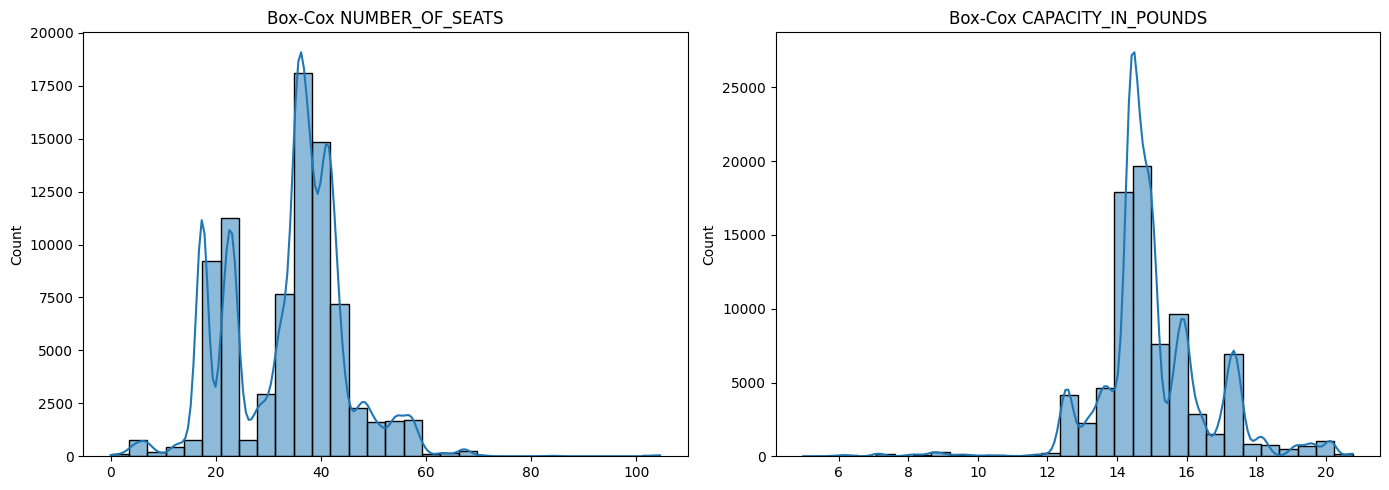

In [15]:
from scipy.stats import boxcox

# Step 1: Filter out non-positive rows
filtered_for_boxcox = aircraft_imputer_cleaned[
    (aircraft_imputer_cleaned['NUMBER_OF_SEATS'] > 0) &
    (aircraft_imputer_cleaned['CAPACITY_IN_POUNDS'] > 0)
].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Step 2: Apply Box-Cox transformations
seats_boxcox, _ = boxcox(filtered_for_boxcox['NUMBER_OF_SEATS'])
capacity_boxcox, _ = boxcox(filtered_for_boxcox['CAPACITY_IN_POUNDS'])

# Step 3: Add transformed columns to the dataset
filtered_for_boxcox['NUMBER_OF_SEATS_BOXCOX'] = seats_boxcox
filtered_for_boxcox['CAPACITY_IN_POUNDS_BOXCOX'] = capacity_boxcox

# Step 4: Plot histograms of the transformed variables
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(seats_boxcox, kde=True, ax=axs[0], bins=30).set_title('Box-Cox NUMBER_OF_SEATS')
sns.histplot(capacity_boxcox, kde=True, ax=axs[1], bins=30).set_title('Box-Cox CAPACITY_IN_POUNDS')
plt.tight_layout()
plt.show()

### Feature engineering

In the first chart, we see that nearly all aircraft are currently operating across every size group, with over 95% in each category marked as active. This suggests that aircraft size doesn't have much impact on whether or not a plane is in operation. However, the second chart shows more variation in aircraft status by size. Smaller planes tend to have a more even split between the different statuses, while larger aircraft, especially those in the XLARGE group, are mostly labeled with status "O." This could mean that although many large planes are technically still operating, they may not be in full use and could be in storage, maintenance, or part of less frequent operations.

<ipython-input-16-2e70fbcc6e1c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aircraft_imputer_cleaned['SIZE'] = pd.cut(aircraft_imputer_cleaned['NUMBER_OF_SEATS'], bins=bins, labels=labels)
<ipython-input-16-2e70fbcc6e1c>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  operating_counts = aircraft_imputer_cleaned.groupby(['SIZE', 'OPERATING_STATUS_BIN']).size().unstack()
<ipython-input-16-2e70fbcc6e1c>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

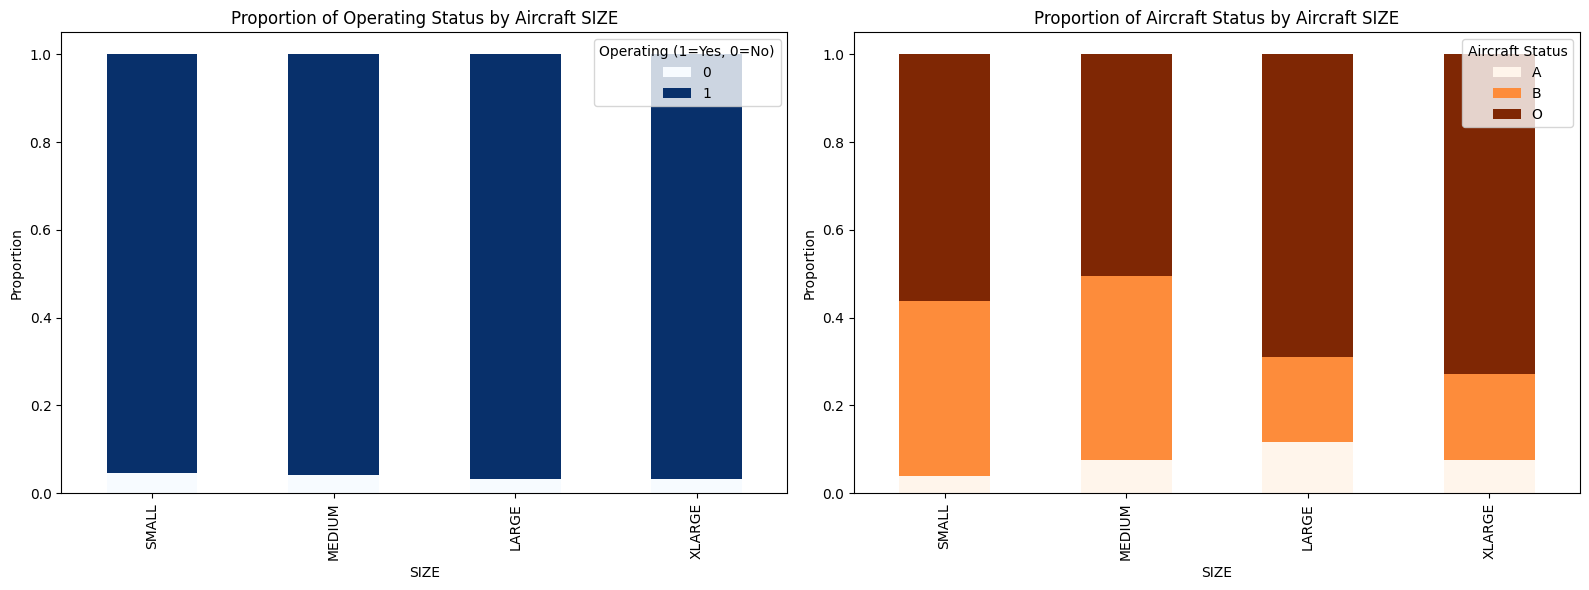

Operating Status Proportions by SIZE:
 OPERATING_STATUS_BIN      0      1
SIZE                              
SMALL                 0.047  0.953
MEDIUM                0.040  0.960
LARGE                 0.033  0.967
XLARGE                0.031  0.969

Aircraft Status Proportions by SIZE:
 AIRCRAFT_STATUS      A      B      O
SIZE                                
SMALL            0.039  0.399  0.562
MEDIUM           0.077  0.418  0.506
LARGE            0.116  0.195  0.689
XLARGE           0.076  0.197  0.728


In [16]:
# Step 1: Create SIZE column based on NUMBER_OF_SEATS quartiles
quartiles = aircraft_imputer_cleaned['NUMBER_OF_SEATS'].quantile([0.25, 0.5, 0.75])
bins = [-np.inf, quartiles[0.25], quartiles[0.5], quartiles[0.75], np.inf]
labels = ['SMALL', 'MEDIUM', 'LARGE', 'XLARGE']
aircraft_imputer_cleaned['SIZE'] = pd.cut(aircraft_imputer_cleaned['NUMBER_OF_SEATS'], bins=bins, labels=labels)

# Step 2: Calculate proportions of OPERATING_STATUS (binary) by SIZE
operating_counts = aircraft_imputer_cleaned.groupby(['SIZE', 'OPERATING_STATUS_BIN']).size().unstack()
operating_proportions = operating_counts.div(operating_counts.sum(axis=1), axis=0)

# Step 3: Calculate proportions of AIRCRAFT_STATUS by SIZE
status_counts = aircraft_imputer_cleaned.groupby(['SIZE', 'AIRCRAFT_STATUS']).size().unstack()
status_proportions = status_counts.div(status_counts.sum(axis=1), axis=0)

# Step 4: Plot proportions for both
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Operating status proportions
operating_proportions.plot(kind='bar', stacked=True, ax=axs[0], colormap='Blues')
axs[0].set_title('Proportion of Operating Status by Aircraft SIZE')
axs[0].set_ylabel('Proportion')
axs[0].legend(title='Operating (1=Yes, 0=No)')

# Plot 2: Aircraft status proportions
status_proportions.plot(kind='bar', stacked=True, ax=axs[1], colormap='Oranges')
axs[1].set_title('Proportion of Aircraft Status by Aircraft SIZE')
axs[1].set_ylabel('Proportion')
axs[1].legend(title='Aircraft Status')

plt.tight_layout()
plt.show()

# Optional: View proportions as tables
print("Operating Status Proportions by SIZE:\n", operating_proportions)
print("\nAircraft Status Proportions by SIZE:\n", status_proportions)